In [306]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy as sp
from scipy.signal import find_peaks
import scipy.constants as const
import pandas as pd
import os
plt.style.use('../report.mplstyle')

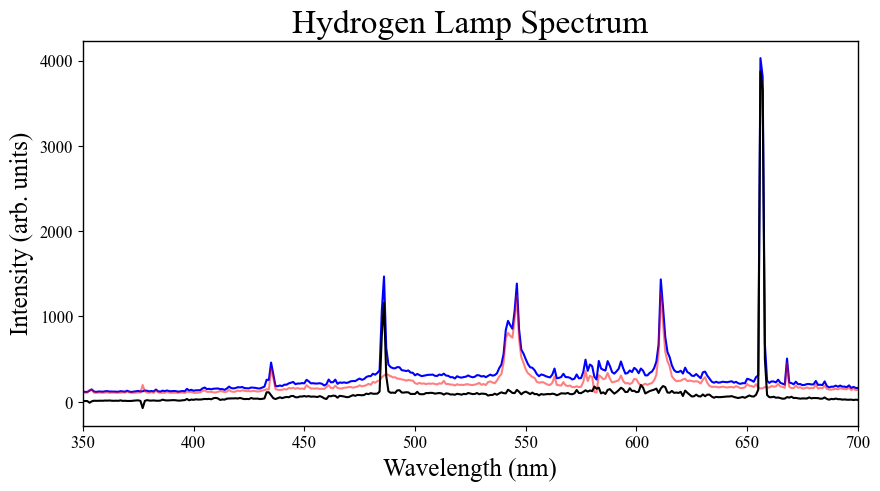

In [307]:
def loadtxt(filename):
    data = np.loadtxt(filename, delimiter='\t', skiprows = 17)
    return data

h_lamp = loadtxt('data/H_lamp/H_lamp0.txt')
background = loadtxt('data/H_lamp/H_lamp_background0.txt')
h_lamp_cor = h_lamp[:,1] - background[:,1]

plt.figure(figsize=(10,5))

plt.plot(h_lamp[:,0], h_lamp[:,1],color = 'blue')
plt.plot(background[:,0], background[:,1], color = 'red',alpha = 0.5)
plt.plot(h_lamp[:,0], h_lamp_cor, color = 'black')
plt.xlabel('Wavelength (nm)')
plt.xlim(350,700)
plt.ylabel('Intensity (arb. units)')
plt.title('Hydrogen Lamp Spectrum')
plt.show()



In [308]:
peaks,peaks_height = find_peaks(h_lamp_cor, height = 45, distance = 22, prominence = 0.1)
peaks = [peaks[0],peaks[1],peaks[3],peaks[9]]
peaks_height = [peaks_height['peak_heights'][0],peaks_height['peak_heights'][1],peaks_height['peak_heights'][3],peaks_height['peak_heights'][9]]


balmer_series = (h_lamp[peaks,0], peaks_height)
wavenumber = (2*np.pi)/(balmer_series[0]*1e-9)
balm_freq = const.c/(balmer_series[0]*1e-9)
energy = const.h*balm_freq
balmer_num = np.array([6,5,4,3])

dic = {
'Wavelength':balmer_series[0],
'Wavenumber': wavenumber,
'Frequency': balm_freq,
'Energy': energy,
'Balmer Number': balmer_num}

balmer = pd.DataFrame(dic)
N1 = 2

In [309]:
def ryd_eq(del_e,n2,n1 = N1):
    x = 1/(n2**2) - 1/(n1**2)
    return del_e/(-const.h*const.c*x)

def ryd_eq3(wavelength,n2,n1 = N1):
    x = 1/(n2**2) - 1/(n1**2)
    return 1/((-wavelength*1e-9)*x)
for i in range(4):
    mean_ryd = (np.mean(ryd_eq(energy[i],balmer_num[i])))
    mean_ryd3 = (np.mean(ryd_eq3(balmer_series[0][i],balmer_num[i])))

def n7(n2,n1 = N1):
    x = 1/(n2**2) - 1/(n1**2)
    return 1/(-mean_ryd*x)

print(f'Fifth Balmer line of hydrogen at {n7(7):.4e}m')


Fifth Balmer line of hydrogen at 3.9684e-07m


FIfth balmer line appears in the spectrum but as a very small peak that could be categorized as noise if it wasnt known to be there

In [310]:
def ion_energy(n):
    return mean_ryd*const.c*const.h/1/(n**2)*1e-3*const.N_A

print(f'First Ionisation energy of hydrogen is {ion_energy(1):.2f} kJ/mol')

First Ionisation energy of hydrogen is 1312.97 kJ/mol


Ionisation energy in eV our value is 13.631 and accepted value in Kaye and Laby is 13.598

# LED section

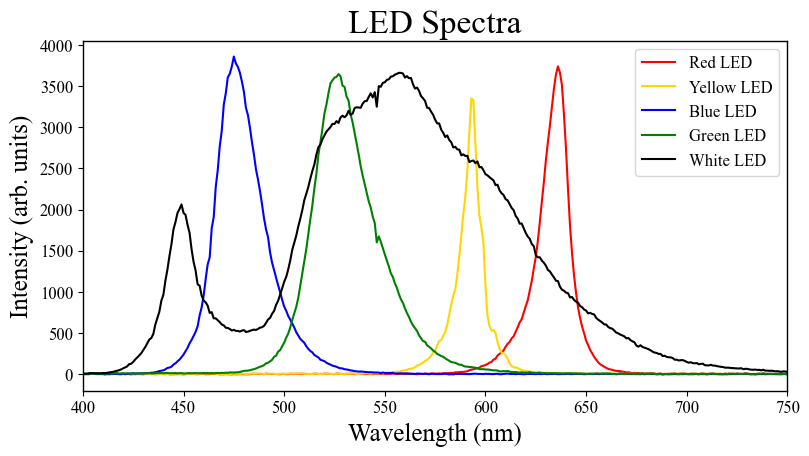

In [311]:
red = loadtxt('data/LED/data/red_led0.txt')
yellow = loadtxt('data/LED/data/yellow_led0.txt')
blue = loadtxt('data/LED/data/blue_led0.txt')
green = loadtxt('data/LED/data/green_led0.txt')
white = loadtxt('data/LED/data/white_led0.txt')
background = loadtxt('data/LED/background_intensity0.txt')

red[:,1] = red[:,1]- background[:,1]
yellow[:,1] = yellow[:,1] - background[:,1]
blue[:,1] = blue[:,1] - background[:,1]
green[:,1] = green[:,1] - background[:,1]
white[:,1] = white[:,1] - background[:,1]

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.plot(red[:,0], red[:,1],color = 'red', label = 'Red LED')
plt.plot(yellow[:,0], yellow[:,1],color = 'gold', label = 'Yellow LED')
plt.plot(blue[:,0], blue[:,1],color = 'blue', label = 'Blue LED')
plt.plot(green[:,0], green[:,1],color = 'green', label = 'Green LED')
plt.plot(white[:,0], white[:,1],color = 'black', label = 'White LED')

plt.xlabel('Wavelength (nm)')
plt.xlim(400,750)
plt.ylabel('Intensity (arb. units)')
plt.title('LED Spectra')
plt.legend()
# plt.subplot(2,2,2)
# plt.plot(red[:,0], red[:,1],color = 'red', label = 'Red LED')
# plt.plot(yellow[:,0], yellow[:,1],color = 'gold', label = 'Yellow LED')
# plt.plot(blue[:,0], blue[:,1],color = 'blue', label = 'Blue LED')
# plt.plot(green[:,0], green[:,1],color = 'green', label = 'Green LED')
# plt.plot(white[:,0], white[:,1],color = 'black', label = 'White LED')
# plt.xlim(800,900)
# plt.show()



In [328]:
path = 'data/LED/data/'
files = os.listdir(path)

peak = []
peaks_heights = []
for file in files:
    data = loadtxt(path+file)
    peaks,peak_heights = find_peaks(data[:,1],height = 3000, distance = 50)
    peak.append(peaks[0])
    peaks_heights.append(peak_heights)
    
print(peaks_heights)

# for i in np.arange(len(peak)):
#     data = loadtxt(path+files[i])
#     intense = (data[peak[i],1])/2
#     edge = data[(data[:,1]- intense).argmin()]
#     print(edge)


[{'peak_heights': array([3747.84])}, {'peak_heights': array([3843.53])}, {'peak_heights': array([3764.81])}, {'peak_heights': array([3453.11])}, {'peak_heights': array([3962.91])}]


In [326]:
from scipy.interpolate import splrep, sproot, splev

class MultiplePeaks(Exception): pass
class NoPeaksFound(Exception): pass

def fwhm(x, y, k=3):
    """
    Determine full-with-half-maximum of a peaked set of points, x and y.

    Assumes that there is only one peak present in the datasset.  The function
    uses a spline interpolation of order k.
    """

    half_max = max(y)/2.0
    s = splrep(x, y - half_max, k=k)
    roots = sproot(s)

    if len(roots) > 2:
        raise MultiplePeaks("The dataset appears to have multiple peaks, and "
                "thus the FWHM can't be determined.")
    elif len(roots) < 2:
        raise NoPeaksFound("No proper peaks were found in the data set; likely "
                "the dataset is flat (e.g. all zeros).")
    else:
        return abs(roots[1] - roots[0])


for file in files:
    if file == 'white_led0.txt':
        pass
    else:
        data = loadtxt(path+file)

        fwhm_val = fwhm(data[:,0],data[:,1])



def energy_peak(wavelength):
    return const.h*const.c/(wavelength*1e-9)
def drive_vol(wavelength):
    return energy(wavelength)/const.e
def energy(wavelength):
    return const.h*const.c/(wavelength*1e-9)

led_data = {
'colour': ['green','red','yellow','blue'],
'peak_wavelength': [green[peak[0],0],red[peak[1],0],yellow[peak[3],0],blue[peak[4],0]],
'peak_intensity': [green[peak[0],1],red[peak[1],1],yellow[peak[3],1],blue[peak[4],1]],
'FWHM': [fwhm(green[:,0],green[:,1]),fwhm(red[:,0],red[:,1]),fwhm(yellow[:,0],yellow[:,1]),fwhm(blue[:,0],blue[:,1])],
'peak_energy': [energy_peak(green[peak[0],0]),energy_peak(red[peak[1],0]),energy_peak(yellow[peak[3],0]),energy_peak(blue[peak[4],0])],
'drive_vol': [drive_vol(green[peak[0],0]),drive_vol(red[peak[1],0]),drive_vol(yellow[peak[3],0]),drive_vol(blue[peak[4],0])],
'energy': [energy(green[:,0]),energy(red[:,0]),energy(yellow[:,0]),energy(blue[:,0])],
'intensity': [green[:,1],red[:,1],yellow[:,1],blue[:,1]]
}


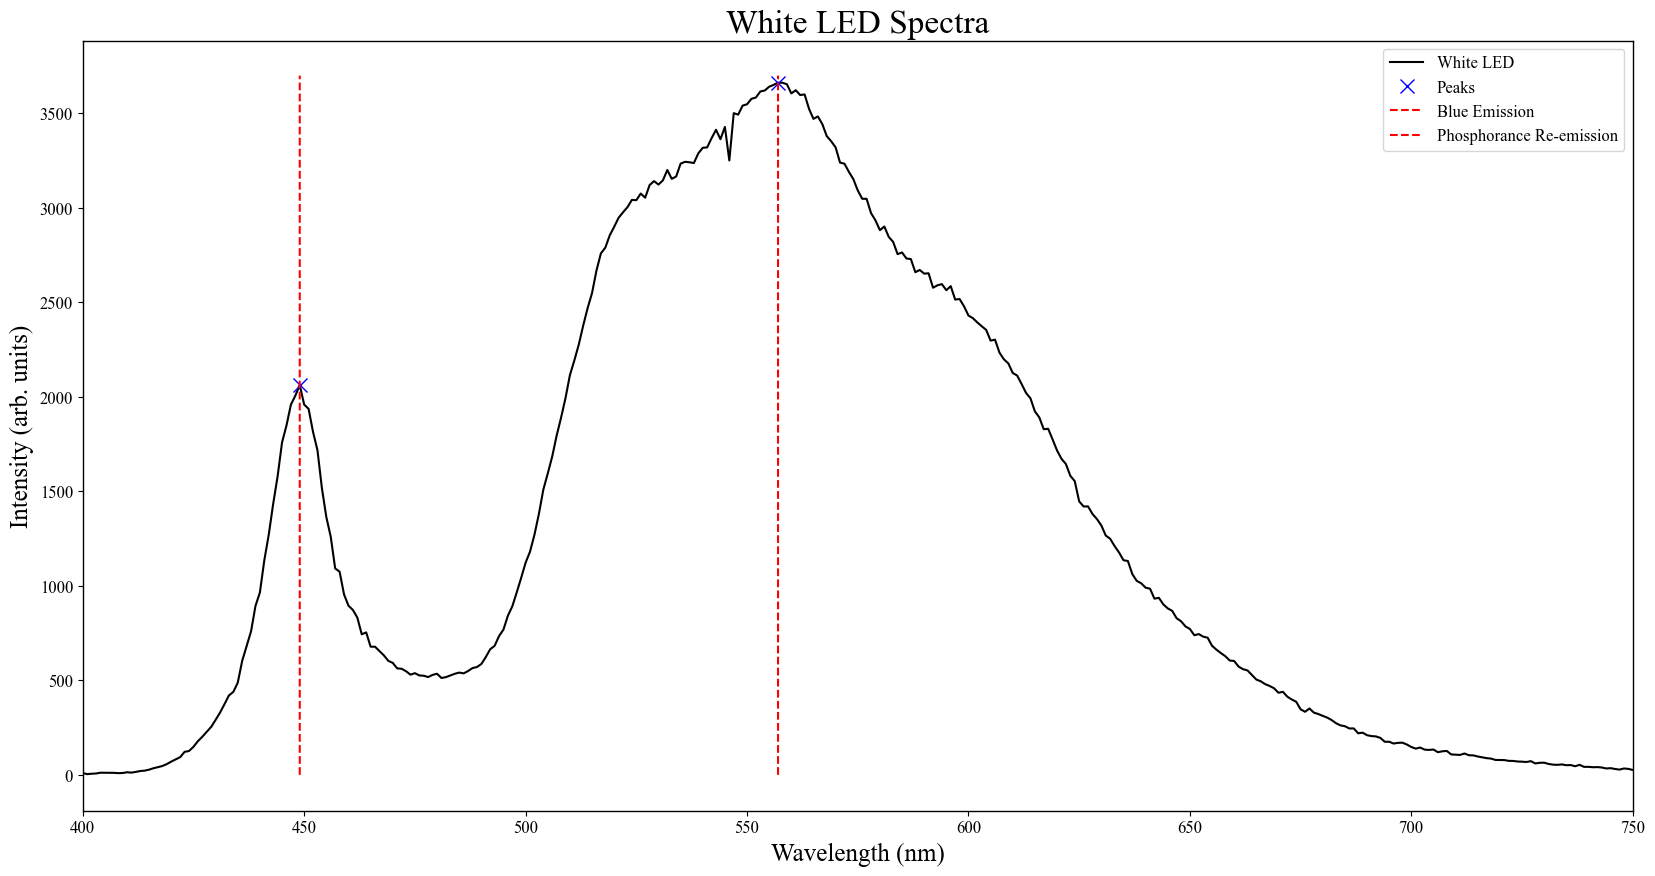

In [ ]:
peaks,peak_heights = find_peaks(white[:,1],height = 2000, distance = 100)

intense = np.linspace(0,3700,10000)
peak_1 = np.full_like(intense,white[peaks[0],0])
peak_2 = np.full_like(intense,white[peaks[1],0])
plt.figure(figsize=(20,10))
plt.plot(white[:,0], white[:,1],color = 'black', label = 'White LED')
plt.plot(white[peaks,0], white[peaks,1], 'x',color = 'blue', label = 'Peaks', markersize = 10)
plt.plot(peak_1, intense, '--',color = 'red', label = 'Blue Emission')
plt.plot(peak_2, intense, '--',color = 'red', label = 'Phosphorance Re-emission')
plt.xlabel('Wavelength (nm)')
plt.xlim(400,750)
plt.ylabel('Intensity (arb. units)')
plt.title('White LED Spectra')
plt.legend()
plt.show()


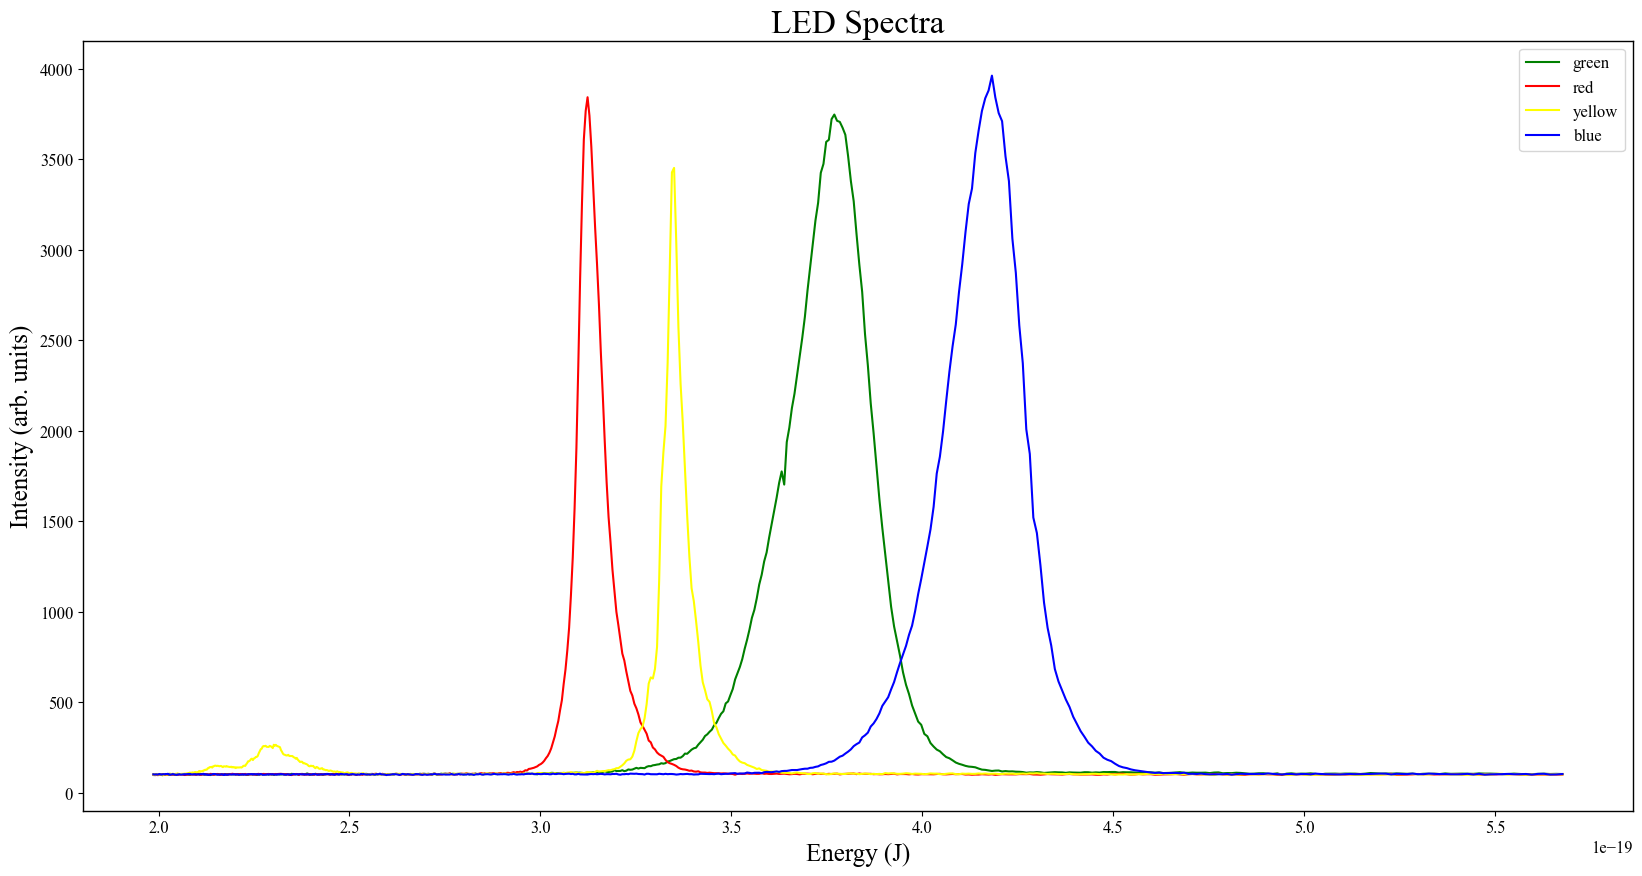

In [ ]:
plt.figure(figsize=(20,10))

for i in np.arange(len(led_data['energy'])):
    plt.plot(led_data['energy'][i],led_data['intensity'][i], label = led_data['colour'][i],color = led_data['colour'][i])
    plt.xlabel('Energy (J)')
    plt.ylabel('Intensity (arb. units)')
    plt.title('LED Spectra')
    plt.legend()
plt.show()




# Birefringment

/var/folders/tn/fqh6631n3p56r504tcsqvss00000gn/T/ipykernel_23843/3565421494.py:10: RuntimeWarning: invalid value encountered in arccos
  del_phi = np.arccos((2*theo_i_para)-1)


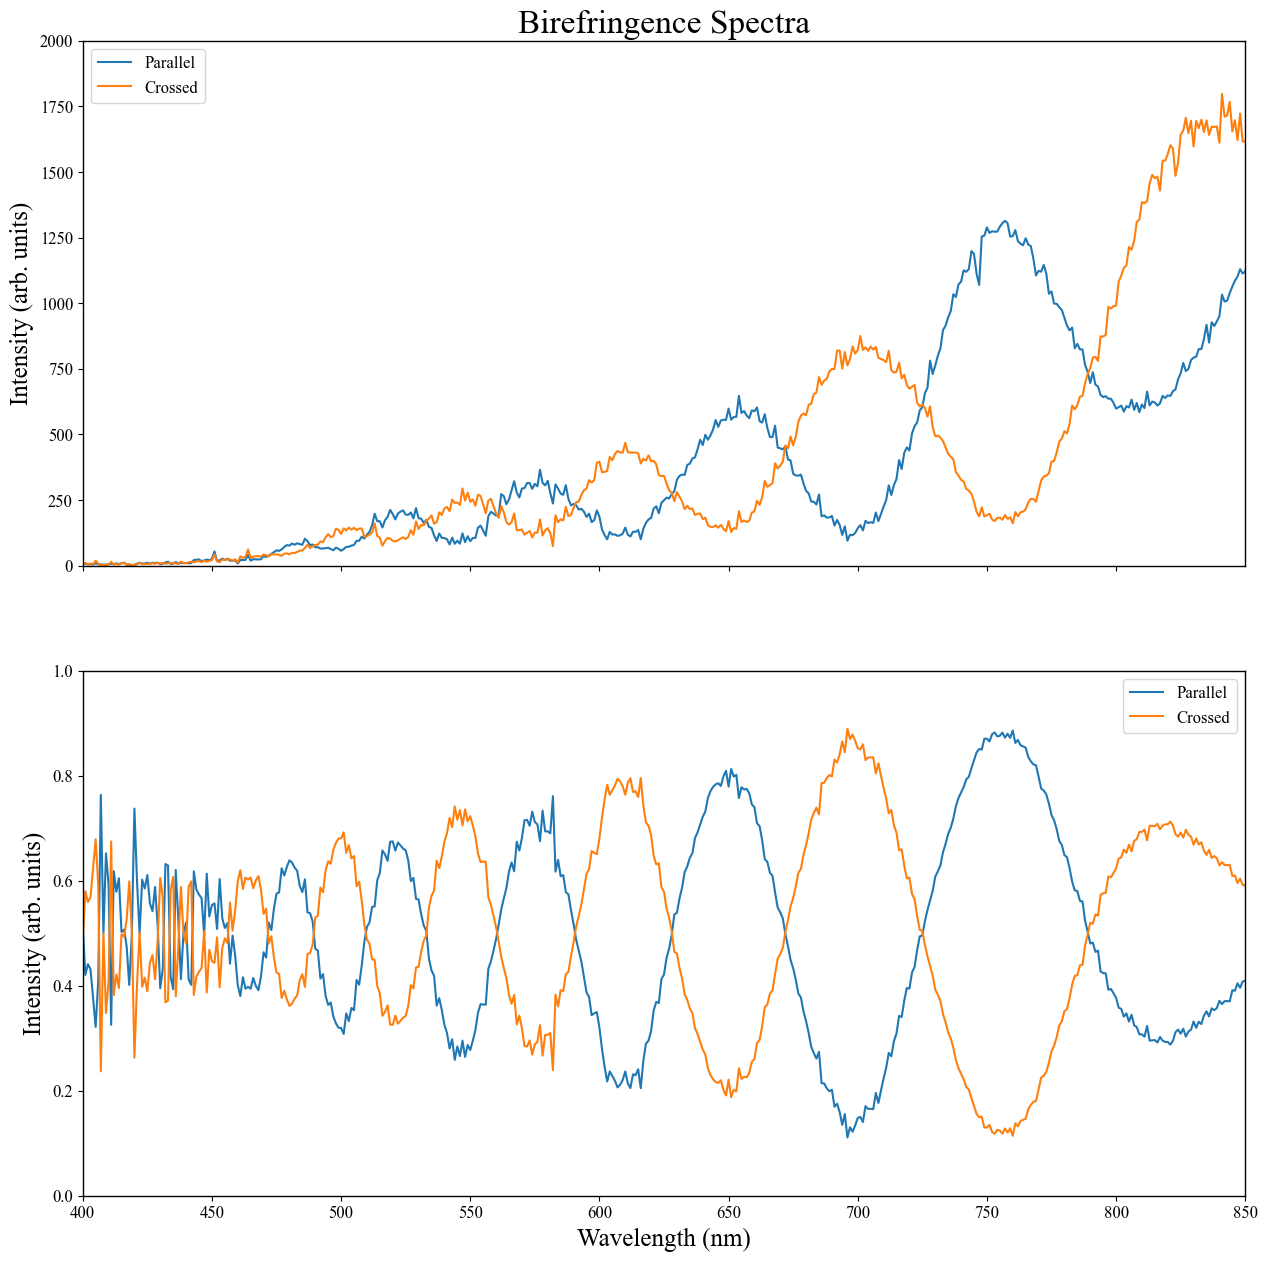

In [ ]:
para = loadtxt('data/birefringement/bi_para0.txt')
cross = loadtxt('data/birefringement/bi_cross0.txt')
back = loadtxt('data/birefringement/bi_back0.txt')

para[:,1] = para[:,1] - back[:,1]
cross[:,1] = cross[:,1] - back[:,1]
theo_i_para = para[:,1]/(para[:,1]+cross[:,1])
theo_i_cross = cross[:,1]/(para[:,1]+cross[:,1])

del_phi = np.arccos((2*theo_i_para)-1)



plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(para[:,0], para[:,1], label = 'Parallel')
plt.plot(cross[:,0], cross[:,1], label = 'Crossed')
plt.xlim(400,850)
plt.xticks(ticks = np.arange(400,850,50),labels = [])
plt.ylabel('Intensity (arb. units)')
plt.ylim(0,2000)
plt.title('Birefringence Spectra')
plt.legend()
plt.subplot(2,1,2)
plt.plot(para[:,0], theo_i_para, label = 'Parallel')
plt.plot(cross[:,0], theo_i_cross, label = 'Crossed')
plt.xlabel('Wavelength (nm)')
plt.xlim(400,850)
plt.ylabel('Intensity (arb. units)')
plt.ylim(0,1)
plt.legend()
plt.show()


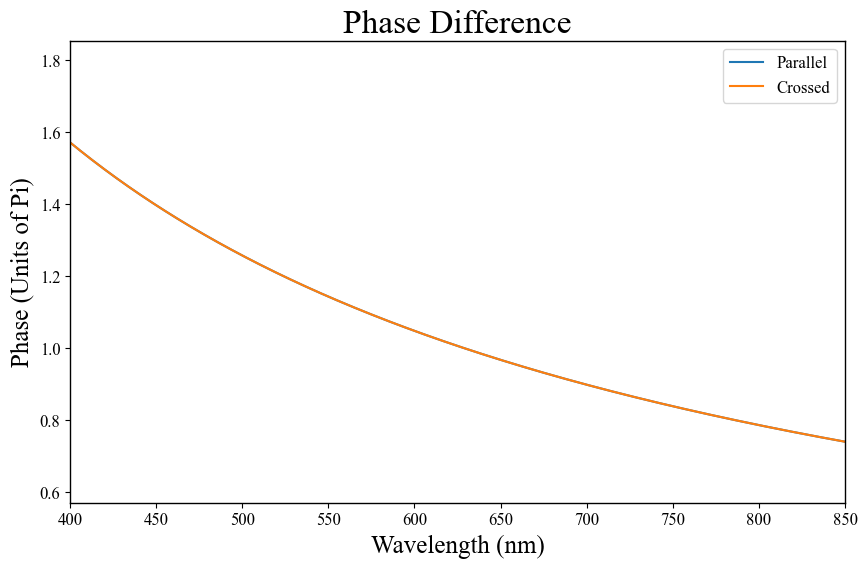

In [ ]:
phase = (2*np.pi/para[:,0])*100
phase_cross = (2*np.pi/cross[:,0])*100
plt.figure(figsize=(10,6))
plt.plot(para[:,0], phase, label = 'Parallel')
plt.plot(cross[:,0], phase_cross, label = 'Crossed')
plt.xlim(400,850)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Phase (Units of Pi)')
plt.title('Phase Difference')
plt.legend()


/var/folders/tn/fqh6631n3p56r504tcsqvss00000gn/T/ipykernel_23843/1084237382.py:1: RuntimeWarning: invalid value encountered in sqrt
  phase_act = 2*np.arctan(np.sqrt((cross[:,1]/para[:,1])))


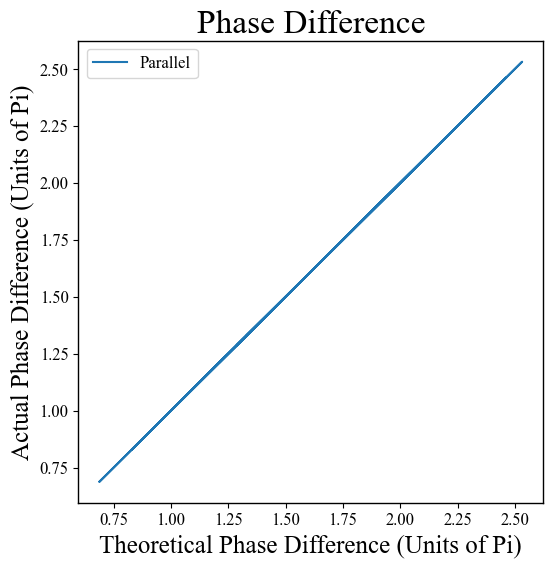

In [ ]:
phase_act = 2*np.arctan(np.sqrt((cross[:,1]/para[:,1])))

plt.figure(figsize=(6,6))
plt.plot(del_phi,phase_act, label = 'Parallel')
plt.xlabel('Theoretical Phase Difference (Units of Pi)')
plt.ylabel('Actual Phase Difference (Units of Pi)')
plt.title('Phase Difference')
plt.legend()
plt.show()

